# Craft beer dataset

In [1]:
# Install required packages
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(kernlab))
suppressPackageStartupMessages(library(IRkernel))
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(skimr))

In [2]:
# Set working directory
setwd("/Users/matthewwilliamhaas/Documents/machine_learning_class/german_rent")

In [3]:
# Read in data
immo <- fread("immo_data.csv")

In [4]:
immo <- immo[baseRent < 5000 & livingSpace < 400 & noRooms < 10] # get rid of outliers-keep only normal sized apartments

In [5]:
head(immo)

state,balcony,totalRent,yearConstructed,baseRent,livingSpace,geo_plz,noRooms,floor,city
Sachsen_Anhalt,TRUE,744,1970,534,97.00,6792,3,3,Sandersdorf
Bayern,TRUE,NA,2005,890,100.00,85126,4,1,Münchsmünster
Bayern,TRUE,530,1967,450,43.00,91056,1,7,Frauenaurach
Sachsen_Anhalt,TRUE,568,1900,396,72.00,39112,2,2,Sudenburg
Schleswig_Holstein,TRUE,1185,2020,995,91.00,24576,3,2,Bad_Bramstedt
Sachsen,TRUE,NA,1911,980,204.68,8058,6,1,Nordvorstadt


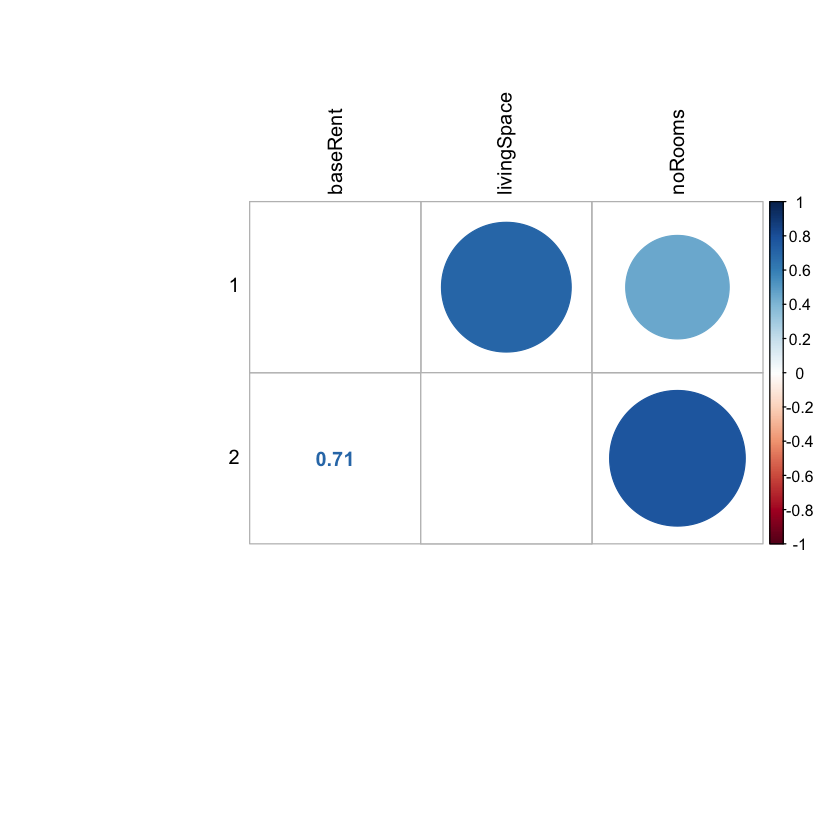

In [6]:
numeric_data <- select_if(immo, is.numeric)

cut_off <- 0.5
var_correlations <- as.data.table(cor(numeric_data, use = 'pairwise.complete.obs')) %>%
                filter(abs(baseRent)> cut_off) %>%
                select_if(~abs(tail(.,1)) > cut_off)
corrplot.mixed(as.matrix(var_correlations),
              tl.col='black', tl.pos = 'lt')

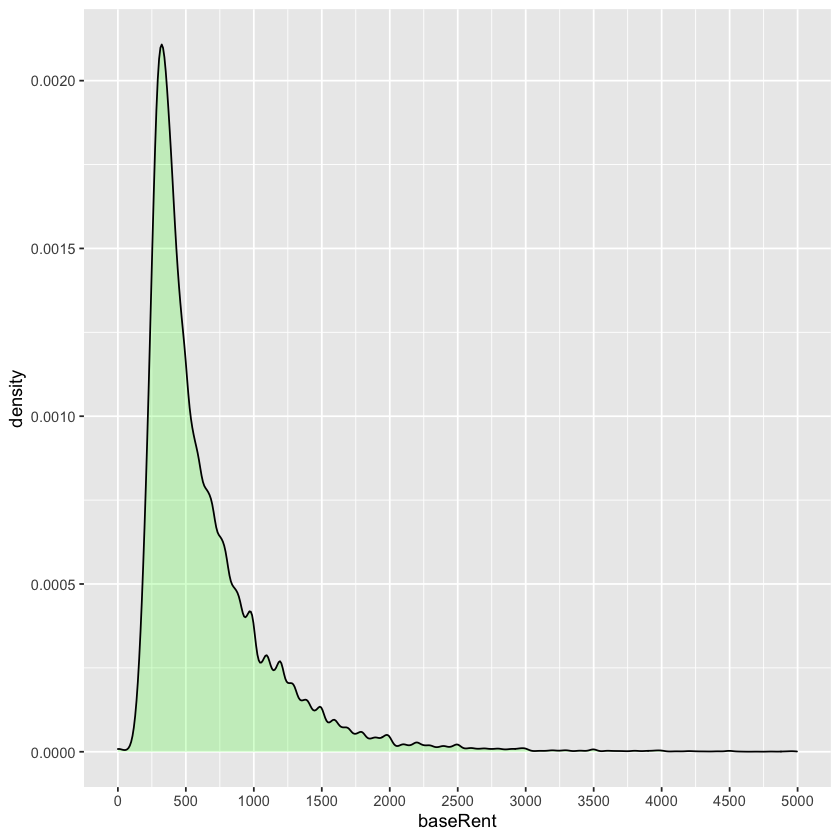

In [7]:
ggplot(immo) +
    geom_density(aes(x=baseRent),fill='green',alpha=0.2) +
    scale_x_continuous(breaks = seq(0,5000, by=500))

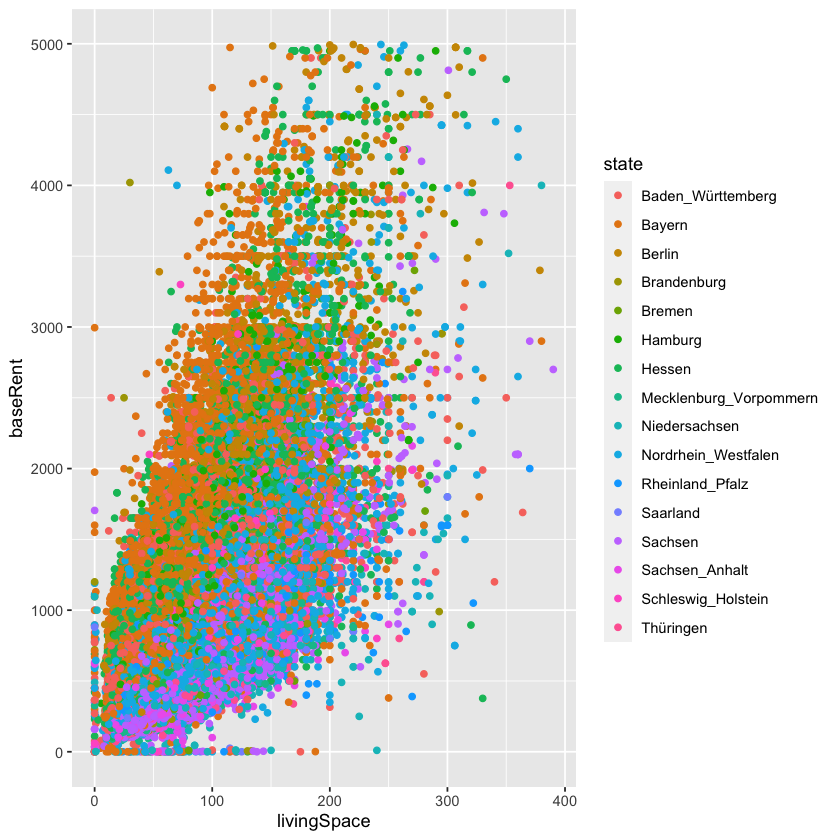

In [8]:
ggplot(immo, aes(x=livingSpace, y=baseRent, color=state)) + geom_point()

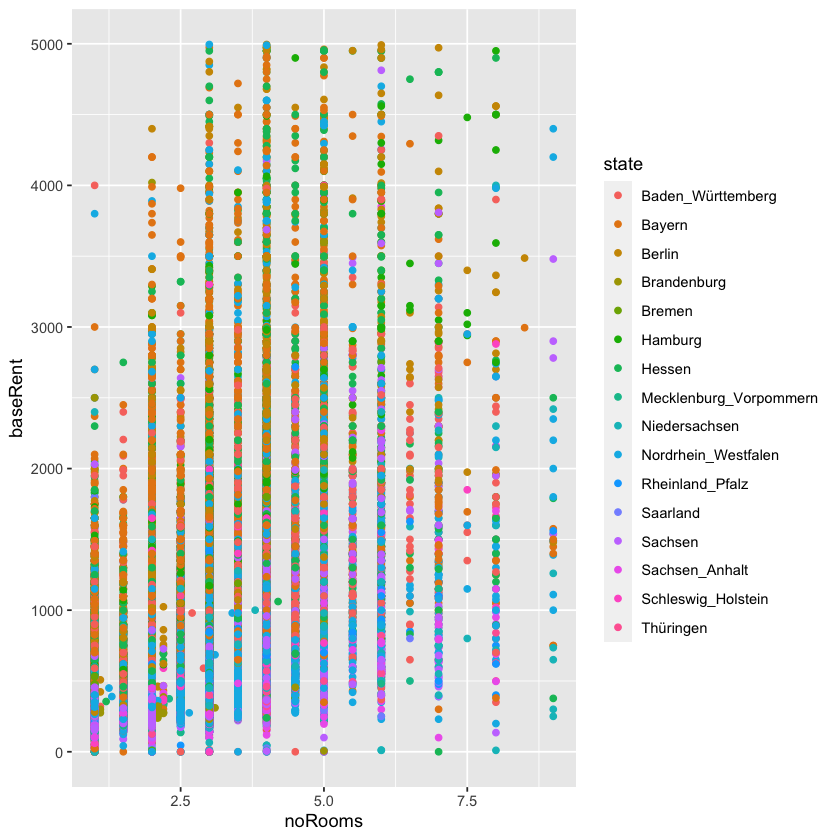

In [9]:
ggplot(immo, aes(x=noRooms, y=baseRent, color=state)) + geom_point()

#### Create partition of training and test data

In [10]:
# Remove NAs
immo_complete <- select_if(immo, function(x) all(!is.na(x))) %>%
                           remove_rownames() %>%
                           select(-geo_plz, -city)

In [11]:
# decision trees
fitControl <- trainControl(
                method ='cv', 
                number = 10, 
                savePredictions = T)

In [12]:
# prepare data
immo_complete_b <- model.matrix(baseRent ~ ., data = immo_complete)
immo_complete_b <- bind_cols(as.data.table(immo_complete_b), select(immo_complete,baseRent))# as.data.table() required to get select() function to work; does not work on matrix 

In [13]:
head(immo_complete_b)

(Intercept),stateBayern,stateBerlin,stateBrandenburg,stateBremen,stateHamburg,stateHessen,stateMecklenburg_Vorpommern,stateNiedersachsen,stateNordrhein_Westfalen,stateRheinland_Pfalz,stateSaarland,stateSachsen,stateSachsen_Anhalt,stateSchleswig_Holstein,stateThüringen,balconyTRUE,livingSpace,noRooms,baseRent
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,97.00,3,534
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,100.00,4,890
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,43.00,1,450
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,72.00,2,396
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,91.00,3,995
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,204.68,6,980


In [14]:
skim(immo)

── Data Summary ────────────────────────
                           Values
Name                       immo  
Number of rows             268529
Number of columns          10    
_______________________          
Column type frequency:           
  character                2     
  logical                  1     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 state                 0             1     6    22     0       16          0
2 city                  0             1     2    54     0     8683          0

── Variable type: logical ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean count                   
1 balcony               0             1 0.616 TRU: 165506, FAL: 103023

── Variable type: numeric ──────────────────

In [15]:
nzv <- nearZeroVar(immo_complete_b, saveMetrics = F)

In [18]:
head(immo_complete_var)

stateBayern,stateBerlin,stateBrandenburg,stateBremen,stateHamburg,stateHessen,stateMecklenburg_Vorpommern,stateNiedersachsen,stateNordrhein_Westfalen,stateRheinland_Pfalz,stateSaarland,stateSachsen,stateSachsen_Anhalt,stateSchleswig_Holstein,stateThüringen,balconyTRUE,livingSpace,noRooms,baseRent
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,97.00,3,534
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,100.00,4,890
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,43.00,1,450
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,72.00,2,396
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,91.00,3,995
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,204.68,6,980


In [17]:
immo_complete_var <- immo_complete_b[,-1]

In [19]:
set.seed(2020)

train_size = 0.75

train_index <- createDataPartition(y = immo_complete_var$baseRent,
                                    p = train_size,
                                   list = F,
                                   time = 1)

train_data <- immo_complete_var[train_index,]
test_data <- immo_complete_var[-train_index,]

In [20]:
dim(train_data)
dim(test_data)

[1] 201398     19

[1] 67131    19

In [22]:
fitControl <- trainControl(method = 'cv', number = 10, savePredictions = T)

test_model <- train(
                    x = select(immo_complete_var, -baseRent),
                    y = immo_complete_var$baseRent,
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

In [23]:
test_model

glmnet 

268529 samples
    18 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241676, 241676, 241675, 241676, 241676, 241677, ... 
Resampling results across tuning parameters:

  alpha  lambda      RMSE      Rsquared   MAE     
  0.10    0.6647058  274.5083  0.6571181  173.4132
  0.10    6.6470584  274.9111  0.6563771  173.3637
  0.10   66.4705841  287.3216  0.6350633  182.3442
  0.55    0.6647058  274.5144  0.6571025  173.3901
  0.55    6.6470584  276.2836  0.6533813  174.0952
  0.55   66.4705841  304.1491  0.6036277  198.0001
  1.00    0.6647058  274.5427  0.6570419  173.3460
  1.00    6.6470584  279.0913  0.6466875  176.3669
  1.00   66.4705841  326.1076  0.5436916  217.6447

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.6647058.

In [24]:
lc_data <- 
    learning_curve_dat (
                    dat = immo_complete_var,
                    outcome = 'baseRent',
                    test_prop = 0.25,
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

Training for 10% (n = 20139)
Training for 20% (n = 40279)
Training for 30% (n = 60419)
Training for 40% (n = 80559)
Training for 50% (n = 100699)
Training for 60% (n = 120838)
Training for 70% (n = 140978)
Training for 80% (n = 161118)
Training for 90% (n = 181258)
Training for 100% (n = 201398)


In [25]:
head(lc_data)

RMSE,Rsquared,MAE,Training_Size,Data
294.2307,0.6118196,181.2151,20139,Resampling
273.9251,0.6659953,176.1563,20139,Resampling
278.8103,0.6236832,177.1738,20139,Resampling
294.0483,0.6464482,181.7076,20139,Resampling
270.8349,0.6340098,176.2696,20139,Resampling
285.9464,0.6603694,171.5968,20139,Resampling


`geom_smooth()` using formula 'y ~ x'



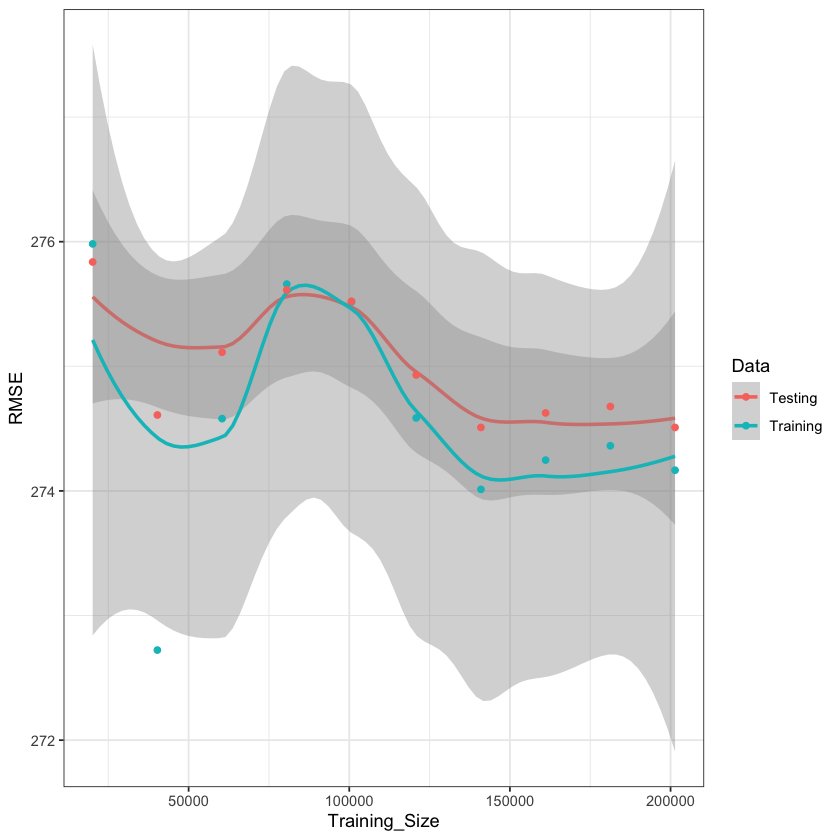

In [26]:
ggplot(filter(lc_data, Data != 'Resampling'), aes(x= Training_Size, y = RMSE, color = Data)) +
        geom_smooth(method = loess, span =0.8) +
        geom_point() +
        theme_bw()

In [27]:
head(immo)

state,balcony,totalRent,yearConstructed,baseRent,livingSpace,geo_plz,noRooms,floor,city
Sachsen_Anhalt,TRUE,744,1970,534,97.00,6792,3,3,Sandersdorf
Bayern,TRUE,NA,2005,890,100.00,85126,4,1,Münchsmünster
Bayern,TRUE,530,1967,450,43.00,91056,1,7,Frauenaurach
Sachsen_Anhalt,TRUE,568,1900,396,72.00,39112,2,2,Sudenburg
Schleswig_Holstein,TRUE,1185,2020,995,91.00,24576,3,2,Bad_Bramstedt
Sachsen,TRUE,NA,1911,980,204.68,8058,6,1,Nordvorstadt


 ## Prediction isn't so great.. maybe because of high disparities between states (esp East & West)

In [28]:
sachsenAnhalt <- immo[state == "Sachsen_Anhalt"]

In [29]:
head(sachsenAnhalt)

state,balcony,totalRent,yearConstructed,baseRent,livingSpace,geo_plz,noRooms,floor,city
Sachsen_Anhalt,TRUE,744.00,1970,534.00,97.00,6792,3,3,Sandersdorf
Sachsen_Anhalt,TRUE,568.00,1900,396.00,72.00,39112,2,2,Sudenburg
Sachsen_Anhalt,FALSE,NA,1950,416.00,69.40,39122,3,1,Westerhüsen
Sachsen_Anhalt,TRUE,437.79,1980,285.45,57.09,6132,3,3,Ortslage_Ammendorf/Beesen
Sachsen_Anhalt,FALSE,391.00,NA,291.00,48.50,38820,2,2,Halberstadt
Sachsen_Anhalt,FALSE,495.20,1994,301.95,60.39,6406,2,2,Bernburg_Saale


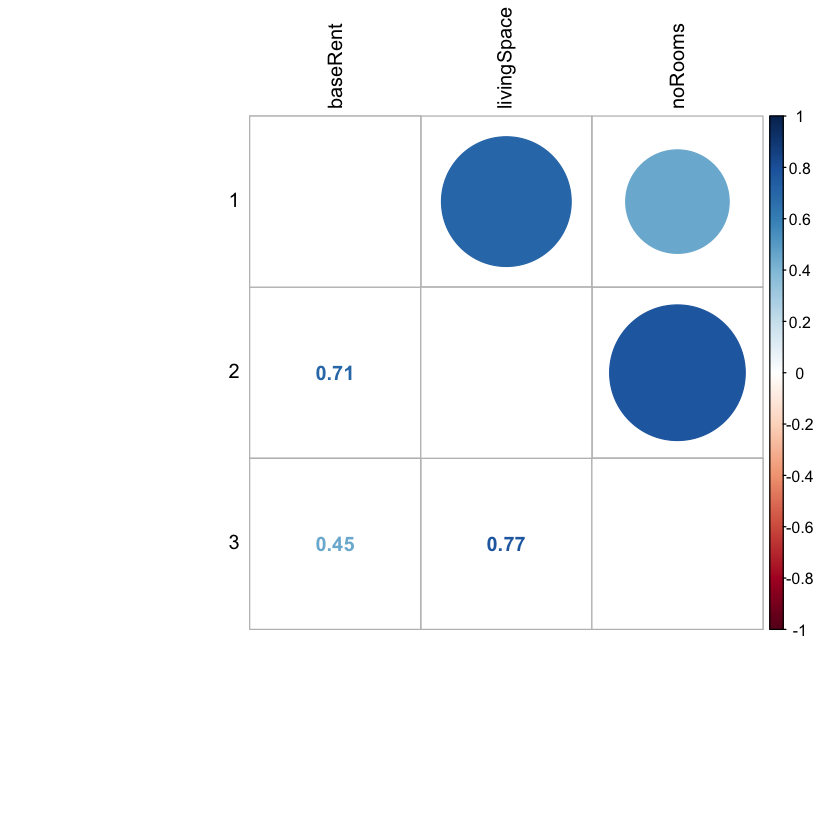

In [30]:
SA_numeric_data <- select_if(immo, is.numeric)

cut_off <- 0.3
SA_var_correlations <- as.data.table(cor(SA_numeric_data, use = 'pairwise.complete.obs')) %>%
                filter(abs(baseRent)> cut_off) %>%
                select_if(~abs(tail(.,1)) > cut_off)
corrplot.mixed(as.matrix(SA_var_correlations),
              tl.col='black', tl.pos = 'lt')

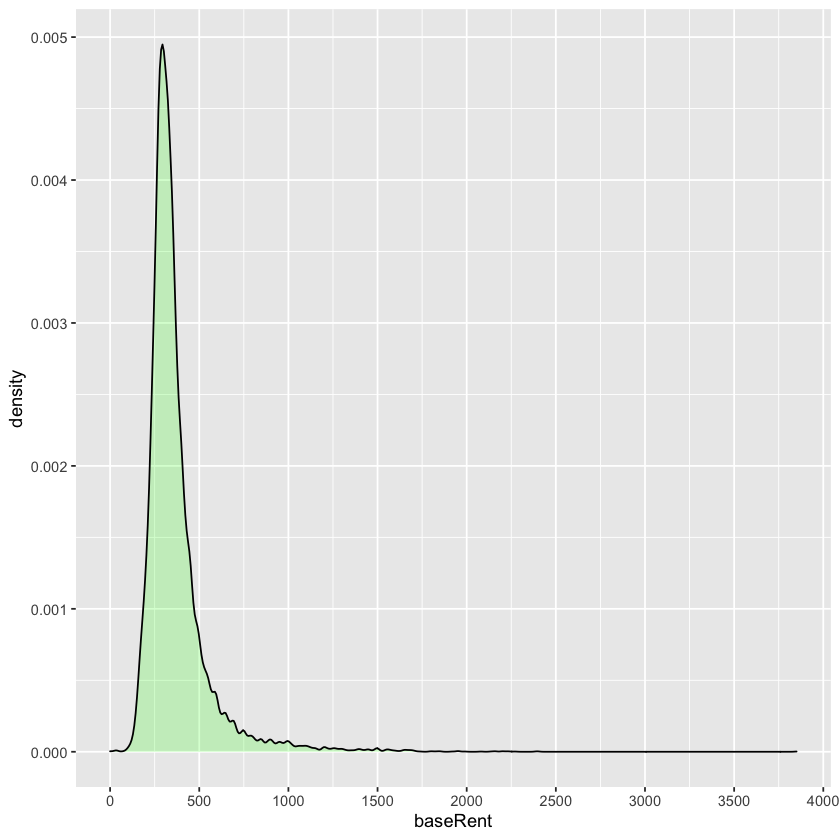

In [31]:
ggplot(sachsenAnhalt) +
    geom_density(aes(x=baseRent),fill='green',alpha=0.2) +
    scale_x_continuous(breaks = seq(0,5000, by=500))

In [32]:
# Remove NAs
SA_complete <- select_if(sachsenAnhalt, function(x) all(!is.na(x))) %>%
                           remove_rownames() %>%
                           select(-geo_plz, -city)

In [36]:
head(SA_complete)

state,balcony,baseRent,livingSpace,noRooms
Sachsen_Anhalt,TRUE,534.00,97.00,3
Sachsen_Anhalt,TRUE,396.00,72.00,2
Sachsen_Anhalt,FALSE,416.00,69.40,3
Sachsen_Anhalt,TRUE,285.45,57.09,3
Sachsen_Anhalt,FALSE,291.00,48.50,2
Sachsen_Anhalt,FALSE,301.95,60.39,2


In [38]:
# prepare data
SA_complete_b <- model.matrix(baseRent ~ livingSpace + noRooms, data = SA_complete)
SA_complete_b <- bind_cols(as.data.table(SA_complete_b), select(SA_complete,baseRent))

In [39]:
head(SA_complete_b)

(Intercept),livingSpace,noRooms,baseRent
1,97.00,3,534.00
1,72.00,2,396.00
1,69.40,3,416.00
1,57.09,3,285.45
1,48.50,2,291.00
1,60.39,2,301.95


In [40]:
nzv <- nearZeroVar(SA_complete_b, saveMetrics = F)

In [42]:
SA_complete_var <- SA_complete_b[,-1]

In [44]:
#set.seed(2020)

#train_size = 0.75

SA_train_index <- createDataPartition(y = SA_complete_var$baseRent,
                                    p = train_size,
                                   list = F,
                                   time = 1)

SA_train_data <- SA_complete_var[SA_train_index,]
SA_test_data <- SA_complete_var[-SA_train_index,]

In [45]:
fitControl <- trainControl(method = 'cv', number = 10, savePredictions = T)

SA_test_model <- train(
                    x = select(SA_complete_var, -baseRent),
                    y = SA_complete_var$baseRent,
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

In [46]:
SA_test_model

glmnet 

20114 samples
    2 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18102, 18104, 18103, 18102, 18101, 18104, ... 
Resampling results across tuning parameters:

  alpha  lambda      RMSE       Rsquared   MAE     
  0.10    0.2984342   98.82659  0.7032559  59.99465
  0.10    2.9843423   98.93800  0.7028789  59.76694
  0.10   29.8434226  104.78485  0.6809029  62.16256
  0.55    0.2984342   98.82764  0.7032505  60.01071
  0.55    2.9843423   99.01689  0.7024474  59.81421
  0.55   29.8434226  105.90824  0.6784613  62.54214
  1.00    0.2984342   98.82697  0.7032487  60.01529
  1.00    2.9843423   99.12816  0.7018245  59.89685
  1.00   29.8434226  107.01523  0.6784613  62.74181

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.2984342.

In [47]:
SA_lc_data <- 
    learning_curve_dat (
                    dat = SA_complete_var,
                    outcome = 'baseRent',
                    test_prop = 0.25,
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

Training for 10% (n = 1508)
Training for 20% (n = 3017)
Training for 30% (n = 4526)
Training for 40% (n = 6034)
Training for 50% (n = 7543)
Training for 60% (n = 9052)
Training for 70% (n = 10560)
Training for 80% (n = 12069)
Training for 90% (n = 13578)
Training for 100% (n = 15087)


In [49]:
head(SA_lc_data)

RMSE,Rsquared,MAE,Training_Size,Data
96.57417,0.7480655,68.22138,1508,Resampling
90.22210,0.6201631,59.35844,1508,Resampling
95.46639,0.7123145,57.42653,1508,Resampling
81.42747,0.6452297,55.15661,1508,Resampling
93.38700,0.7758401,56.61800,1508,Resampling
70.87332,0.7042529,49.98096,1508,Resampling


`geom_smooth()` using formula 'y ~ x'



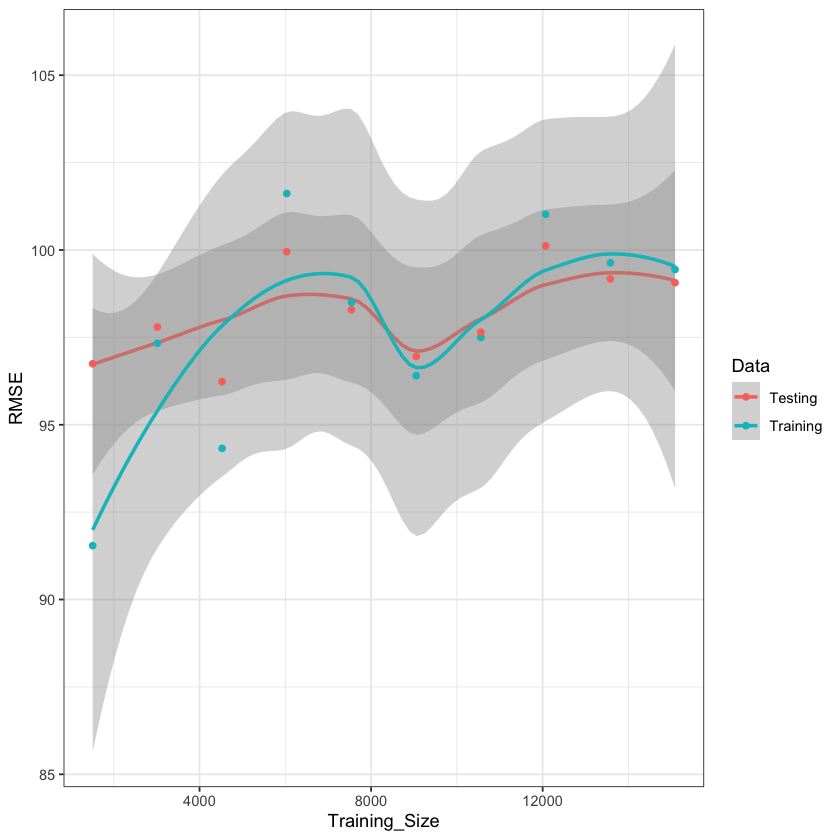

In [50]:
ggplot(filter(SA_lc_data, Data != 'Resampling'), aes(x= Training_Size, y = RMSE, color = Data)) +
        geom_smooth(method = loess, span =0.8) +
        geom_point() +
        theme_bw()

In [51]:
SA_test_model <- train(
                    x = select(SA_complete_var, -baseRent),
                    y = SA_complete_var$baseRent,
                    method = 'rf',
                    trControl = fitControl,
                    metric = 'RMSE')

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



In [52]:
SA_test_model

Random Forest 

20114 samples
    2 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18103, 18103, 18101, 18104, 18103, 18102, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  97.00666  0.7150705  55.32663

Tuning parameter 'mtry' was held constant at a value of 2

In [53]:
SA_rf_lc_data <- 
    learning_curve_dat (
                    dat = SA_complete_var,
                    outcome = 'baseRent',
                    test_prop = 0.25,
                    method = 'rf',
                    trControl = fitControl,
                    metric = 'RMSE')

Training for 10% (n = 1508)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 20% (n = 3017)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 30% (n = 4526)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 40% (n = 6034)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 50% (n = 7543)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 60% (n = 9052)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 70% (n = 10560)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 80% (n = 12069)
note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

Training for 90% (n = 13578)
note: only 1 unique complexity parameters in defa

`geom_smooth()` using formula 'y ~ x'



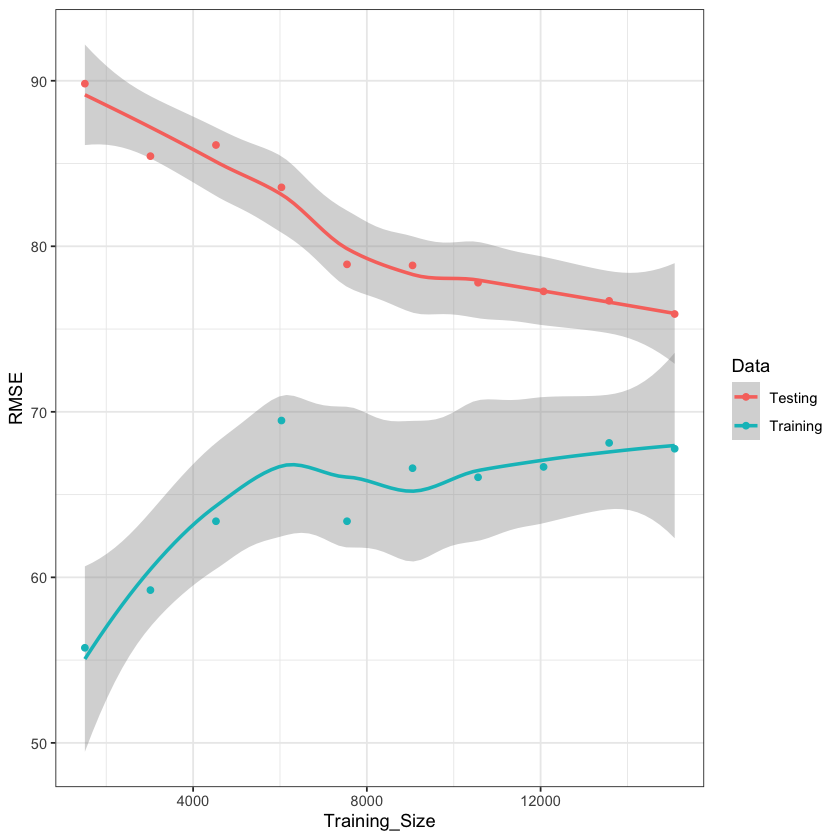

In [54]:
ggplot(filter(SA_rf_lc_data, Data != 'Resampling'), aes(x= Training_Size, y = RMSE, color = Data)) +
        geom_smooth(method = loess, span =0.8) +
        geom_point() +
        theme_bw()